In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from datetime import date



# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
#Get the list of the measurement
columns = inspector.get_columns('measurement') 
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
#Get the list of the measurement
columns = inspector.get_columns('station') 
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [15]:
# Total dates
session.query(func.count(Measurement.date)).all()

[(19550)]

In [16]:
# Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [17]:
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [18]:
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
last_year

datetime.date(2016, 8, 23)

In [19]:
data = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=last_year).all()

In [20]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date>= last_year).\
        all()
results[0:7]



[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0)]

In [21]:
prcp_analysis = pd.DataFrame(data, columns=["date", "precipitation"])
prcp_analysis.set_index(prcp_analysis["date"], inplace=True)

#prcp_analysis = prcp_analysis.rename(columns={'prcp':"precipitation"})
#prcp_analysis = prcp_analysis.groupby(by='date').mean()
prcp_analysis.head()



,date,precipitation
date,,
2016-08-23,2016-08-23,0.00
2016-08-24,2016-08-24,0.08
2016-08-25,2016-08-25,0.08
2016-08-26,2016-08-26,0.00
2016-08-27,2016-08-27,0.00


In [22]:
#SORT THE DATAFRAME BY DATE
prcp_analysis.drop("date", axis=1, inplace=True)
prcp_analysis = prcp_analysis.sort_values("date")
prcp_analysis.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


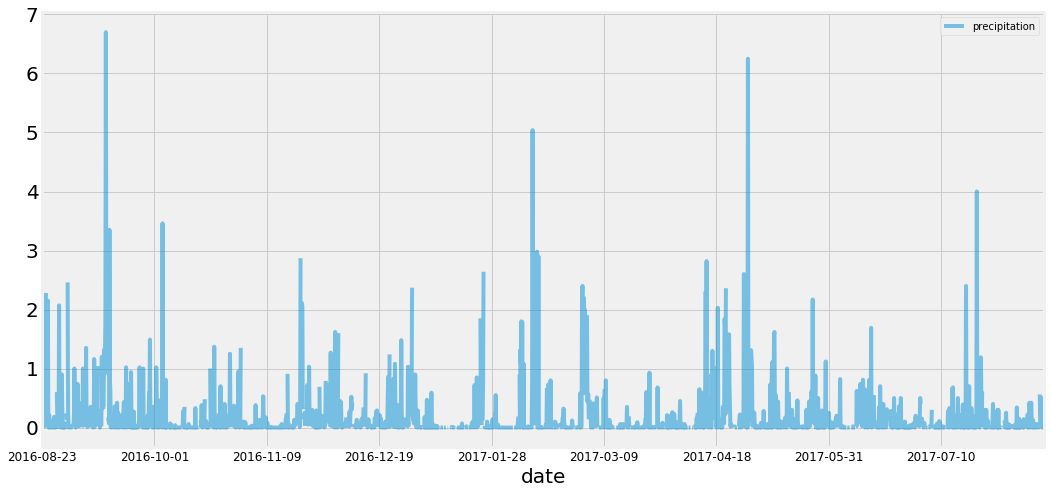

In [23]:
# Use Pandas Plotting with Matplotlib to plot the data
plt_dimensions = plt.rcParams["figure.figsize"]
plt_dimensions[0] = 16.0
plt_dimensions[1] = 8.0
plt.rcParams["figure.figsize"] = plt_dimensions
#fig  = plt.figure(figsize=(16,9),facecolor = 'blue')
plt.tight_layout
prcp_analysis.plot(x_compat=False, alpha=0.5)

plt.yticks(size=20)
plt.xlabel('date', size=20)
plt.legend()
plt.xticks(size=12)
plt.savefig('prcp.png')
plt.show()




In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_analysis.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# Design a query to show how many stations are available in this dataset?
station_df = session.query(Station.id).count()
station_df


9

In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Station.station, func.count(Measurement.station).label('actives')).\
              filter(Station.station == Measurement.station).\
              group_by(Station.station).\
              order_by(func.count(Measurement.station).desc()).\
              all()
most_active


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
active_one = most_active[0].station
print(f'Most active is {active_one}')

Most active is USC00519281


In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

temp_record = [func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)]

temp_record_query = session.query(*temp_record).\
                    filter(Measurement.station == active_one).\
                    all()

temp_record_df = list(np.ravel(temp_record_query))

print(f'Result is {temp_record_query}')
        




Result is [(54.0, 85.0, 71.66378066378067)]


In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results = session.query(Measurement.station, Measurement.tobs).\
        filter(Measurement.date>= last_year).\
        filter(Measurement.station == active_one).\
        all()
results[0:10]


[('USC00519281', 77.0),
 ('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0),
 ('USC00519281', 75.0),
 ('USC00519281', 73.0),
 ('USC00519281', 78.0),
 ('USC00519281', 77.0),
 ('USC00519281', 78.0),
 ('USC00519281', 80.0)]

In [30]:
hist_df = pd.DataFrame(results, columns=['Stations', 'Tobs'])
hist_df.head

<bound method NDFrame.head of         Stations  Tobs
0    USC00519281  77.0
1    USC00519281  77.0
2    USC00519281  80.0
3    USC00519281  80.0
4    USC00519281  75.0
..           ...   ...
347  USC00519281  77.0
348  USC00519281  77.0
349  USC00519281  76.0
350  USC00519281  76.0
351  USC00519281  79.0

[352 rows x 2 columns]>

<function matplotlib.pyplot.show(*args, **kw)>

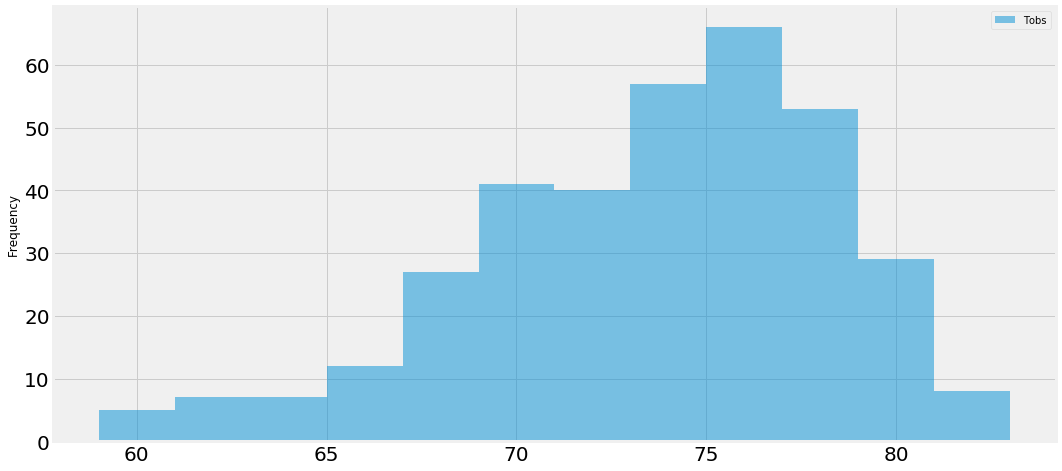

In [31]:
hist_df.plot.hist(bins=12, alpha=0.5)
plt.yticks(size=20)
plt.xticks(size=20)
plt.tight_layout
plt.savefig('hist.png')
plt.show

In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [33]:
# Calculate 1 year ago
end_df = dt.date(2012, 2, 28)
year_df = end_df - dt.timedelta(days=365)

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


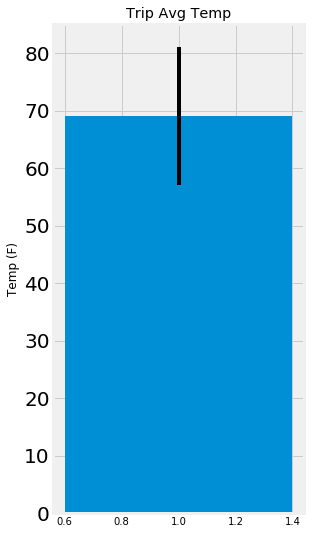

In [34]:
#Plot the result
tmax = 74
tmin = 62
tavg = 69
temp_calc = tmax - tmin

#plt.plot[(0,20,20,60,80,100), color='orange']
plt.figure(figsize=(4, 9))
plt.tick_params(bottom='off', top='off', labelbottom='off')
plt.yticks(size=20)
plt.bar(1, tavg, yerr=temp_calc)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.savefig('temp.png')
plt.show()

In [37]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
end_df = dt.date(2012, 5, 3)
year_ago = end_df - dt.timedelta(days=365)

sel = [Measurement.station, Measurement.prcp, Station.name, Station.longitude, Station.latitude, Station.elevation]

rainfall_df = session.query(*sel).\
    filter(Measurement.date <= end_df).\
    filter(Measurement.date >= year_ago).\
    group_by(Station.name).\
    order_by(Measurement.prcp).all()
rainfall_df


[('USC00519397',
  0.02,
  'HONOLULU OBSERVATORY 702.2, HI US',
  -157.9992,
  21.3152,
  0.9),
 ('USC00519397', 0.02, 'KANEOHE 838.1, HI US', -157.8015, 21.4234, 14.6),
 ('USC00519397',
  0.02,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  -157.8374,
  21.5213,
  7.0),
 ('USC00519397',
  0.02,
  'MANOA LYON ARBO 785.2, HI US',
  -157.8025,
  21.3331,
  152.4),
 ('USC00519397', 0.02, 'PEARL CITY, HI US', -157.9751, 21.3934, 11.9),
 ('USC00519397',
  0.02,
  'UPPER WAHIAWA 874.3, HI US',
  -158.0111,
  21.4992,
  306.6),
 ('USC00519397',
  0.02,
  'WAIHEE 837.5, HI US',
  -157.84888999999998,
  21.45167,
  32.9),
 ('USC00519397', 0.02, 'WAIKIKI 717.2, HI US', -157.8168, 21.2716, 3.0),
 ('USC00519397',
  0.02,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  -157.71139,
  21.33556,
  19.5)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


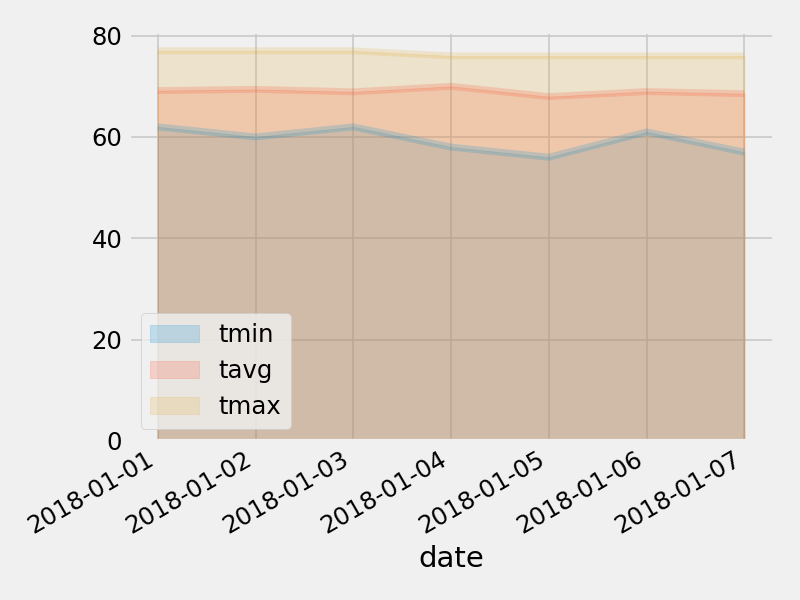

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
